In [4]:
!pip install pydot
!apt-get install -y graphviz

zsh:1: command not found: apt-get


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import plot_model


2023-04-12 22:10:27.295907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
path_prefix = "/content/gdrive/MyDrive/733_final_project/sentiment"

import sys
sys.path.insert(1, path_prefix)

Mounted at /content/gdrive


In [3]:
!ls "/content/gdrive/My Drive/733-final-project/sentiment"


BTC_tweets_daily_example.csv	     Twitter+data+in+sheets.xlsx
Cleaned_filtered_BTC_tweets.csv      twitter_kaggle_training.csv
Cleaned_Twitter_data_in_sheets.csv   twitter_kaggle_training.gsheet
Cleaned_twitter_kaggle_training.csv  twitter_kaggle_validation.csv
combined_df.csv


In [4]:
datasets_folder = '/content/gdrive/My Drive/733-final-project/sentiment'

In [51]:
# Load dataset
# df = pd.read_csv(datasets_folder+"/Cleaned_twitter_kaggle_training.csv")
# df = pd.read_csv(datasets_folder+"/Cleaned_Twitter_data_in_sheets.csv")
df = pd.read_csv(datasets_folder+"/combined_df.csv")

df = df.dropna(subset=['sent_score', 'Cleaned_Tweet'])

In [52]:
df.head()

,Cleaned_Tweet,sent_score
0,"Paul Krugman, Nobel Luddite. I had to tweak th...",0.0
1,But (dum b a ss) said you know nothing about ...,0.0
2,Another use case for blockchain and Tipper. Th...,1.0
3,free coins,1.0
4,WE are happy to announce that PayVX Presale Ph...,1.0


In [53]:
df['Cleaned_Tweet'].dtypes

dtype('O')

In [54]:
unique_values = df['sent_score'].value_counts()
print(unique_values)

 0.0    107371
 1.0     70570
-1.0     33833
Name: sent_score, dtype: int64


In [55]:
df['Cleaned_Tweet'] = df['Cleaned_Tweet'].astype(str)

In [56]:

X = df['Cleaned_Tweet'].values
y = df['sent_score'].values

# Encoding the labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = to_categorical(y, num_classes=3)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert the text to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Padding the sequences
max_seq_length = 250
X_train = pad_sequences(X_train, maxlen=max_seq_length)
X_test = pad_sequences(X_test, maxlen=max_seq_length)

# Model definition
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_seq_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GRU(128))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
5295/5295 [==============================] - 174s 32ms/step - loss: 0.4585 - accuracy: 0.8179 - val_loss: 0.3561 - val_accuracy: 0.8643
Epoch 2/10
5295/5295 [==============================] - 147s 28ms/step - loss: 0.2843 - accuracy: 0.8940 - val_loss: 0.2913 - val_accuracy: 0.8931
Epoch 3/10
5295/5295 [==============================] - 146s 28ms/step - loss: 0.2059 - accuracy: 0.9249 - val_loss: 0.2751 - val_accuracy: 0.9063
Epoch 4/10
5295/5295 [==============================] - 146s 28ms/step - loss: 0.1521 - accuracy: 0.9447 - val_loss: 0.2579 - val_accuracy: 0.9133
Epoch 5/10
5295/5295 [==============================] - 146s 28ms/step - loss: 0.1174 - accuracy: 0.9575 - val_loss: 0.2568 - val_accuracy: 0.9185
Epoch 6/10
5295/5295 [==============================] - 146s 28ms/step - loss: 0.0915 - accuracy: 0.9661 - val_loss: 0.2792 - val_accuracy: 0.9210
Epoch 7/10
5295/5295 [==============================] - 146s 28ms/step - loss: 0.0720 - accuracy: 0.9729 - val_loss: 0

In [59]:
model.save(datasets_folder+'/Bidirectional_LSTM.h5')

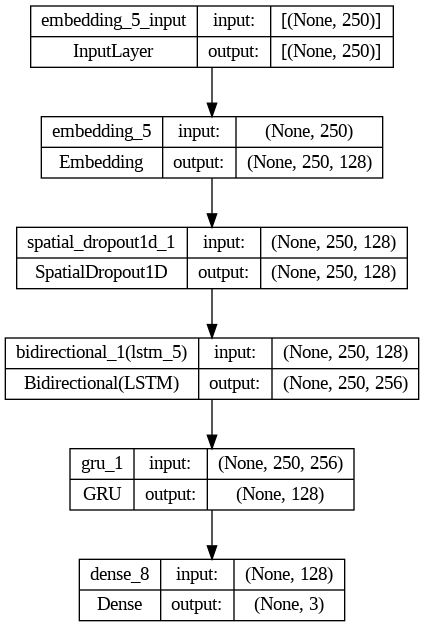

In [63]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=96)

# Display the image
from IPython.display import Image
Image(filename='model.png')

In [65]:
from keras.models import load_model
# from keras.preprocessing.sequence import pad_sequences

def predict_sentiment(input_string, model_path, tokenizer, max_seq_length=250):
    # Load the saved model
    model = load_model(model_path)

    # Preprocess the input string
    input_string = [input_string]  # Convert the string to a list containing the string
    tokenized_input = tokenizer.texts_to_sequences(input_string)
    padded_input = tf.keras.utils.pad_sequences(tokenized_input, maxlen=max_seq_length)

    # Predict the sentiment
    prediction = model.predict(padded_input)

    # Decode the prediction
    sentiment_class = encoder.inverse_transform([np.argmax(prediction)])

    return sentiment_class[0]

# Example usage:
input_string = "A story which continue today. Received a call from my patient that I took care in Covid ward,HKL last year, makcik came to see me again today to give kuih raya made by her & husband. Kuih Semperit, Tart Nenas & Cornflakes. Ya Allah, makcik, you deserve all love in this world"
model_path = datasets_folder + "/Bidirectional_LSTM.h5"
sentiment = predict_sentiment(input_string, model_path, tokenizer)
print("The sentiment of the input string is:", sentiment)


1/1 [==============================] - 1s 949ms/step
The sentiment of the input string is: 1.0
